<a href="https://colab.research.google.com/github/malekzitouni/Generative-AI-with-diffusion-Models/blob/main/Denoising_and_Generating_Fashion_with_U_Net_A_FashionMNIST_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install torchview


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# Visualization tools
import graphviz
from torchview import draw_graph
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

## 1.1 The Dataset

FashionMNIST is included in Torchvision, a computer vision library associated with PyTorch. When we download the dataset, we can pass a list of transformations we would like to apply to the images. For now, we will use ToTensor to convert the images into a tensors so we can process the images with a neural network. This will automatically scale the pixel values from [0, 255] to [0, 1]. It will also rearrange the dimensions to be from [Height x Width x Channels] to [Channels x Height x Width].

In [ ]:
train_set = torchvision.datasets.FashionMNIST(
    "./data/", download=True, transform=transforms.Compose([transforms.ToTensor()])
)
NUM_CLASSES = 10

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.8MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.70MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.45MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



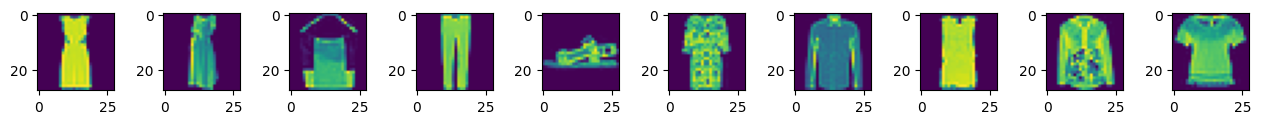

In [ ]:
# Adjust for display; high w/h ratio recommended
plt.figure(figsize=(16, 1))

def show_images(dataset, num_samples=10):
    for i, img in enumerate(dataset):
        if i == num_samples:
            return
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(torch.squeeze(img[0]))

show_images(train_set)

In [ ]:
IMG_SIZE = 16 # Due to stride and pooling, must be divisible by 2 multiple times
IMG_CH = 1 # Black and white image, no color channels
BATCH_SIZE = 128

Now that we have defined the target size of our images, let's create a function to load the data and transform it to the target size. The random noise we will be adding to our images will be sampled from a [standard normal distribution](https://mathworld.wolfram.com/NormalDistribution.html), meaning 68% of the noise pixel values will be from -1 to 1. We will similarly scale our image values to be from -1 to 1.

This would also be a good place to apply random image augmentation. For now, we will start with a [RandomHorizontalFlip](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip). We won't use a [RandomVericalFlip](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomVerticalFlip.html#torchvision.transforms.RandomVerticalFlip) because we would end up generating upside down images.

In [ ]:
def load_fashionMNIST(data_transform, train=True):
    return torchvision.datasets.FashionMNIST(
        "./",
        download=True,
        train=train,
        transform=data_transform,
    )


def load_transformed_fashionMNIST():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),  # Scales pixel values from the range [0, 255] (for grayscale) to [0, 1].
        transforms.RandomHorizontalFlip(), # This is an augmentation technique that helps the model generalize by creating variations in the data.
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scales the pixel values from [0, 1] to [-1, 1].
    ]

    data_transform = transforms.Compose(data_transforms)
    train_set = load_fashionMNIST(data_transform, train=True)
    test_set = load_fashionMNIST(data_transform, train=False)
    return train_set, test_set

In [ ]:
train_set, test_set = load_transformed_fashionMNIST()

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


## 1.2 The U-Net Architecture

First, let's define the different components of our U-Net architecture. Primarily, the `DownBlock` and the `UpBlock`.

### 1.2.1 The Down Block

The `DownBlock` is a typical convolutional neural network. If you are new to PyTorch and are coming from a Keras/TensorFlow background, the below is more similar to the [functional API](https://keras.io/guides/functional_api/) instead of a [sequential model](https://keras.io/guides/sequential_model/). We will later be using [residual](https://stats.stackexchange.com/questions/321054/what-are-residual-connections-in-rnns) and skip connections. A sequential model does not have the flexibility to support these types of connections, but a functional model does.

In our `__init__` function below, we will assign our various neural network operations to class variables:
* [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) applies convolution to the input. The `in_ch` is the number of channels we are convolving over and `out_ch` is the number of output channels, which is the same as the number of kernel filters used for convolution. Typically in a U-Net architecture, the number of channels increase the further down we move in the model.
* [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) is the activation function for the convolution kernels.
* [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) applies [batch normalization](https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338) to a layer of neurons. ReLu has no learnable parameters, so we can apply the same function to multiple layers and it will have the same effect as using multiple ReLu functions. Batch Normalization does have learnable parameters, and reusing this function can have unexpected effects.
* [MaxPool2D](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) is what we'll use to reduce the size of our feature map as it moves down the network. It's possible to achieve this effect through convolution, but max pooling is commonly used with U-Nets.

In the `forward` method, we describe how are various functions should be applied to an input. So far, the operations are sequential in this order:
* `Conv2d`
* `BatchNorm2d`
* `ReLU`
* `Conv2d`
* `BatchNorm2d`
* `ReLU`
* `MaxPool2d`

In [ ]:
class DownBlockEncoder(nn.Module):
    def __init__(self, in_ch, out_ch):
        kernel_size = 3
        stride = 1
        padding = 1

        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ]
        self.model = nn.Sequential(*layers) # When you pass an input to this module, it will apply the layers sequentially in the order defined in the layers list.

    def forward(self, x):
        return self.model(x) # Apply  all the layers (convolution, batch normalization, activation, and max pooling) in sequence.

In [ ]:
ch, h, w = 1, 3, 3
x = torch.ones(1, ch, h, w)
x

tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])

In [ ]:
kernel = torch.tensor([[1.]])  # Identity kernel
kernel = kernel.view(1, 1, 1, 1).repeat(1, ch, 1, 1) # Make into a batch
kernel
output = F.conv_transpose2d(x, kernel, stride=1, padding=0, output_padding=0)[0]
output

tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]])

In [ ]:
kernel_size = 3
kernel = torch.ones(1, 1, kernel_size, kernel_size)
output1 = F.conv2d(x, kernel, stride=1, padding=1)[0]
output2 = F.conv_transpose2d(x, kernel, stride=1, padding=0, output_padding=0)[0]


In [ ]:
# Print x, kernel, and output
print("Input (x):")
print(x)
print("\nKernel:")
print(kernel)
print("\nOutput1 after convolution:")
print(output1)  # Print the first (and only) element of the batch

print("\nOutput2 after convolution:")
print(output2)  # Print the first (and only) element of the batch

Input (x):
tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])

Kernel:
tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])

Output1 after convolution:
tensor([[[4., 6., 4.],
         [6., 9., 6.],
         [4., 6., 4.]]])

Output2 after convolution:
tensor([[[1., 2., 3., 2., 1.],
         [2., 4., 6., 4., 2.],
         [3., 6., 9., 6., 3.],
         [2., 4., 6., 4., 2.],
         [1., 2., 3., 2., 1.]]])


Another interesting difference: we will be multiplying the input channel by 2. This is to accommodate the skip connections. We will be concatenating the output of an `UpBlock`'s matching `DownBlock` with the `UpBlock`'s input.


If x is the size of the input feature map, the output size is:

`new_x = (x - 1) * stride + kernel_size - 2 * padding + out_padding`

If stride = 2 and out_padding = 1, then in order to double the size of the input feature map:

`kernel_size = 2 * padding + 1`

The operations are almost the same as before, but with two differences:
* `ConvTranspose2d` - Convolution Transpose instead of Convolution
* `BatchNorm2d`
* `ReLU`
* `Conv2d`
* `BatchNorm2d`
* `ReLU`
* ~~`MaxPool2d`~~ - Scaling up instead of down

Transposed Convolution: Used in UpBlock instead of standard convolution to upscale the feature maps.

-Skip Connections: Concatenates the feature map from the encoder with the current input.

-Upscaling: UpBlock increases spatial dimensions, while DownBlock decreases them.

. Skip Connections

The feature map output from the DownBlock (from the encoder) is concatenated with the input to the corresponding UpBlock (in the decoder).
This concatenation increases the number of input channels to the UpBlock.
If the feature map has
2
c channels, the concatenated input to the UpBlock will have
2c channels.
Skip connections allow the network to retain high-resolution spatial details from earlier layers, improving the quality of the reconstruction.

In [ ]:
class UpBlockDecoder(nn.Module):
    def __init__(self, in_ch, out_ch):
        # Convolution variables
        kernel_size = 3
        stride = 1
        padding = 1

        # Transpose variables
        strideT = 2
        out_paddingT = 1

        super().__init__()
        # 2 * in_chs for concatednated skip connection
        layers = [
            nn.ConvTranspose2d(2 * in_ch, out_ch, kernel_size, strideT, padding, out_paddingT),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

### 1.2.3 A Full U-Net

It's finally time to piece it together! Below, we have our full `UNet` model.

In the `__init__` function, we can define the number of channels at each step of the U-Net with `down_chs`. The current default is `(16, 32, 64)` meaning the current dimensions of the data as it moves through the model are:

* input: 1 x 16 x 16
* down0: 16 x 16 x 16
  * down1: 32 x 8 x 8
    * down2: 64 x 4 x 4
      * dense_emb: 1024
    * up0: 64 x 4 x 4
  * up1: 64 x 8 x 8
* up2: 32 x 16 x 16
* out: 1 x 16 x 16

The `forward` class method is where we will finally add our skip connections. For each step down in the U-Net, we will keep track of the output of each `DownBlock`. Then, when we move through the `UpBlock`s, we will [concatenate](https://pytorch.org/docs/stable/generated/torch.cat.html) the output of the previous `UpBlock` with its corresponding `DownBlock`.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_ch = IMG_CH
        down_chs = (16, 32, 64)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)

        # Inital convolution
        self.down0 = nn.Sequential(
            nn.Conv2d(img_ch, down_chs[0], 3, padding=1),
            nn.BatchNorm2d(down_chs[0]),
            nn.ReLU()
        )

        # Downsample
        self.down1 = DownBlockEncoder(down_chs[0], down_chs[1])
        self.down2 = DownBlockEncoder(down_chs[1], down_chs[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            nn.Conv2d(up_chs[0], up_chs[0], 3, padding=1),
            nn.BatchNorm2d(up_chs[0]),
            nn.ReLU(),
        )
        self.up1 = UpBlockDecoder(up_chs[0], up_chs[1])
        self.up2 = UpBlockDecoder(up_chs[1], up_chs[2])

        # Match output channels
        self.out = nn.Sequential(
            nn.Conv2d(up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.BatchNorm2d(up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_ch, 3, 1, 1),
        )

    def forward(self, x):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0, down2)
        up2 = self.up2(up1, down1)
        return self.out(up2)

In [ ]:
model = UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  372257


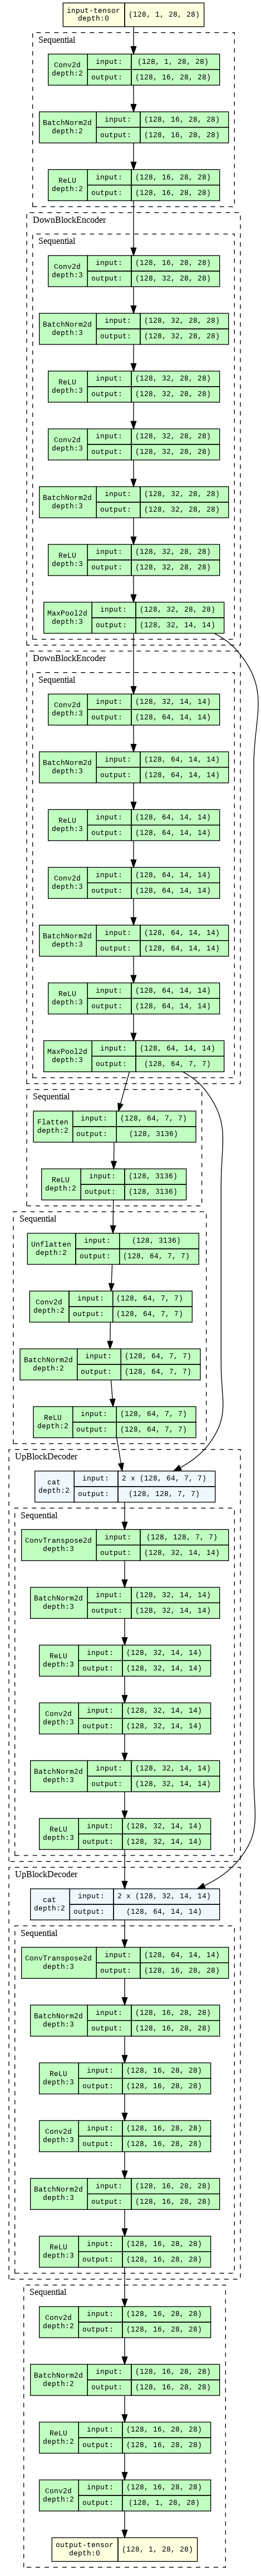

In [ ]:
graphviz.set_jupyter_format('png')
model_graph = draw_graph(
    model,
    input_size=(BATCH_SIZE, IMG_CH, IMG_SIZE, IMG_SIZE),
    device='meta',
    expand_nested=True
)
model_graph.resize_graph(scale=1.5)
model_graph.visual_graph

In [ ]:
model = torch.compile(UNet().to(device))

In [ ]:
def add_noise(imgs):
    dev = imgs.device  # Get the device (CPU or GPU) where the input tensor resides.
    percent = 0.5  # Fraction of noise to add. Change this value to control noise level.
    beta = torch.tensor(percent, device=dev)  # Weight for the noise component.  Determines how much noise is added.
    alpha = torch.tensor(1 - percent, device=dev)  # Weight for the original image. Determines how much of the original image is retained.
    noise = torch.randn_like(imgs)  # generates random values sampled from a standard normal distribution
    return alpha * imgs + beta * noise  # Blend the original image and noise.



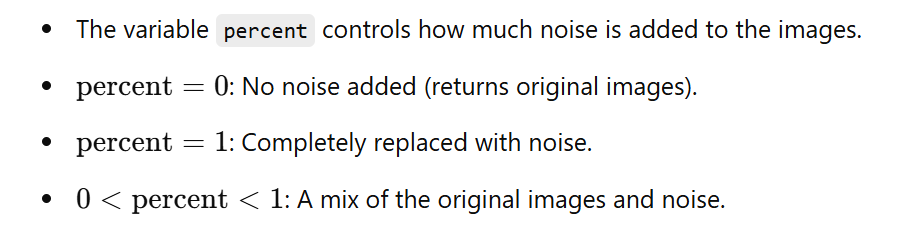

In [ ]:
def get_loss(model, imgs):
    imgs_noisy = add_noise(imgs)
    imgs_pred = model(imgs_noisy)
    return F.mse_loss(imgs, imgs_pred)

In [ ]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(image[0].detach().cpu()))

In [ ]:
@torch.no_grad()
def plot_sample(imgs):
    # Take first image of batch
    imgs = imgs[[0], :, :, :]
    imgs_noisy = add_noise(imgs[[0], :, :, :])
    imgs_pred = model(imgs_noisy)

    nrows = 1
    ncols = 3
    samples = {
        "Original" : imgs,
        "Noise Added" : imgs_noisy,
        "Predicted Original" : imgs_pred
    }
    for i, (title, img) in enumerate(samples.items()):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_title(title)
        show_tensor_image(img)
    plt.show()

Epoch 0 | Step 000 Loss: 0.817664623260498 


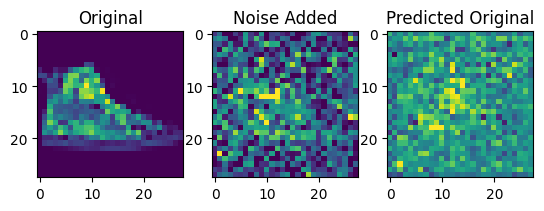

Epoch 0 | Step 100 Loss: 0.11933095008134842 


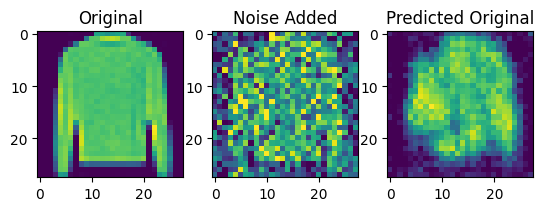

Epoch 0 | Step 200 Loss: 0.0949045717716217 


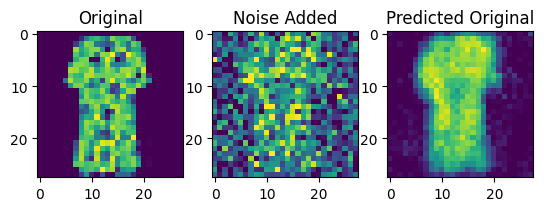

Epoch 0 | Step 300 Loss: 0.08102376759052277 


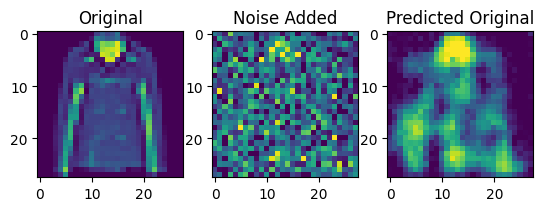

Epoch 0 | Step 400 Loss: 0.0784342810511589 


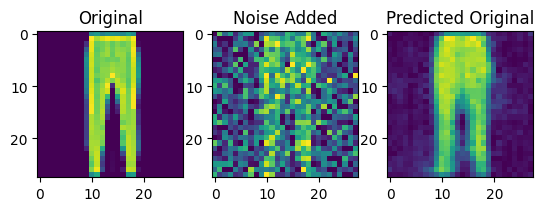

Epoch 1 | Step 000 Loss: 0.0735754668712616 


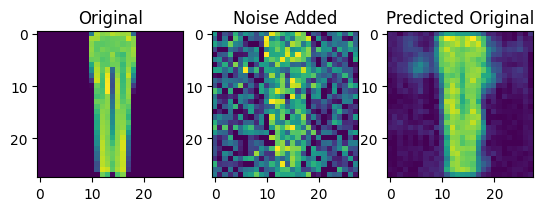

Epoch 1 | Step 100 Loss: 0.07134517282247543 


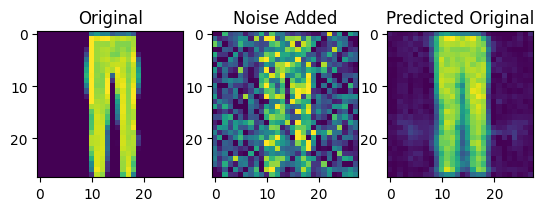

Epoch 1 | Step 200 Loss: 0.06570838391780853 


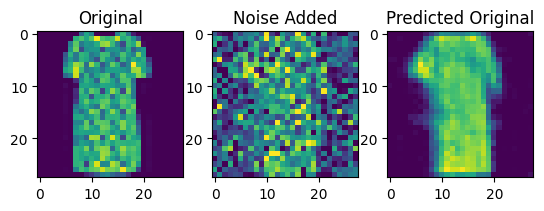

Epoch 1 | Step 300 Loss: 0.06917095929384232 


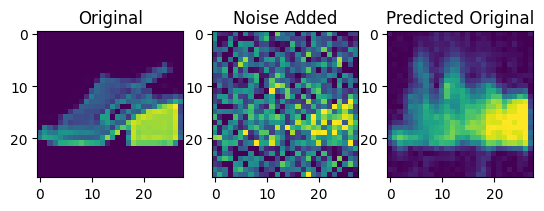

Epoch 1 | Step 400 Loss: 0.06437868624925613 


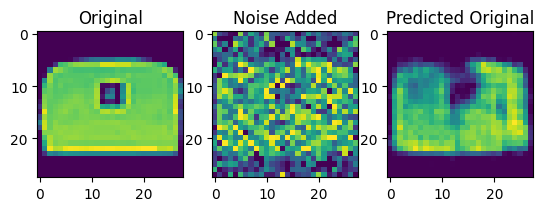

Epoch 2 | Step 000 Loss: 0.06681123375892639 


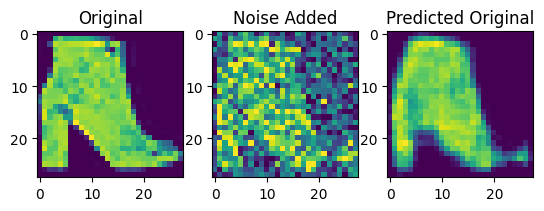

Epoch 2 | Step 100 Loss: 0.06689233332872391 


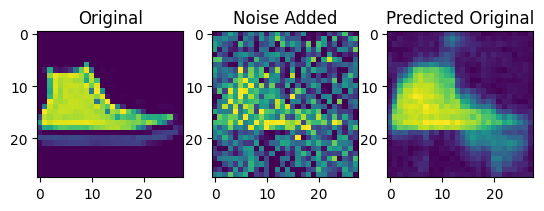

Epoch 2 | Step 200 Loss: 0.05815102159976959 


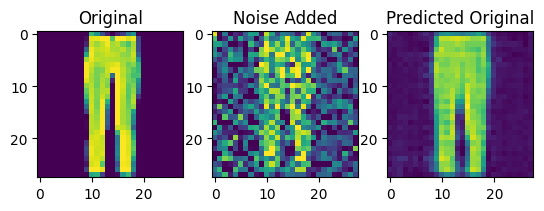

Epoch 2 | Step 300 Loss: 0.059715721756219864 


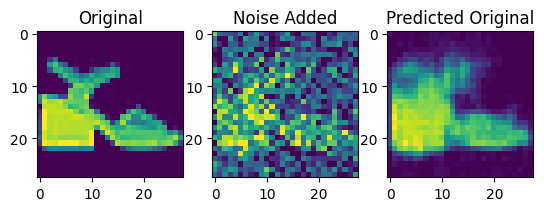

Epoch 2 | Step 400 Loss: 0.058115143328905106 


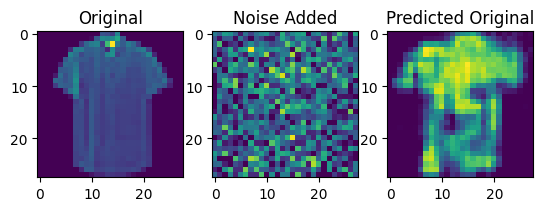

Epoch 3 | Step 000 Loss: 0.05421490967273712 


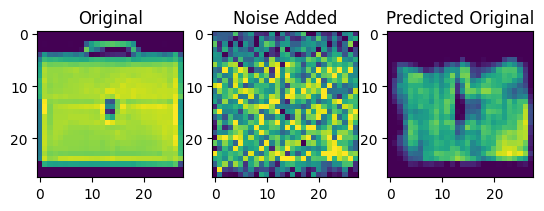

Epoch 3 | Step 100 Loss: 0.06074301153421402 


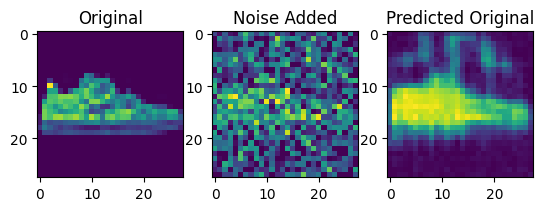

Epoch 3 | Step 200 Loss: 0.05782690271735191 


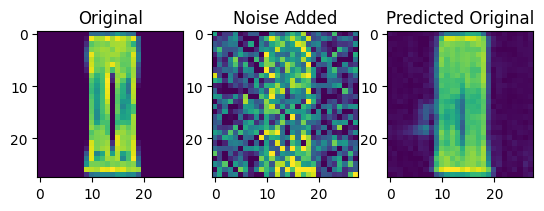

Epoch 3 | Step 300 Loss: 0.05667353793978691 


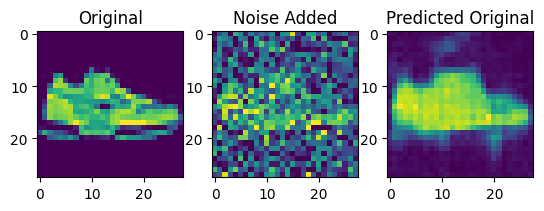

Epoch 3 | Step 400 Loss: 0.05630194768309593 


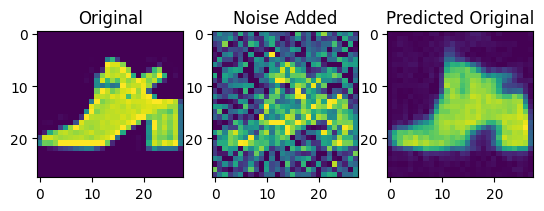

In [ ]:
import torch
from torch.optim import Adam

# Ensure device is set to CPU
device = torch.device("cpu")
model.to(device)

optimizer = Adam(model.parameters(), lr=0.0001)
epochs = 4

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()

        # Move images to the appropriate device (CPU in this case)
        images = batch[0].to(device)

        # Compute loss
        loss = get_loss(model, images)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Print progress
        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch} | Step {step:03d} Loss: {loss.item()} ")
            plot_sample(images)


In [ ]:
model.eval()  # Set model to evaluation mode

total_loss = 0
total_samples = 0
num_batches = 0

with torch.no_grad():  # Disable gradient computation for efficiency
    for step, batch in enumerate(test_loader):
        # Move images to the appropriate device
        images = batch[0].to(device)

        # Compute loss
        loss = get_loss(model, images)
        total_loss += loss.item()

        # Increment counters
        total_samples += images.size(0)
        num_batches += 1

        # Print progress
        if step % 100 == 0:
            print(f"Step {step:03d}, Loss: {loss.item()}")


# Calculate average loss over the entire test dataset
average_loss = total_loss / num_batches
print(f"Test Set Evaluation - Average Loss: {average_loss:.4f}")


Step 000, Loss: 0.05498092621564865
Test Set Evaluation - Average Loss: 0.0568


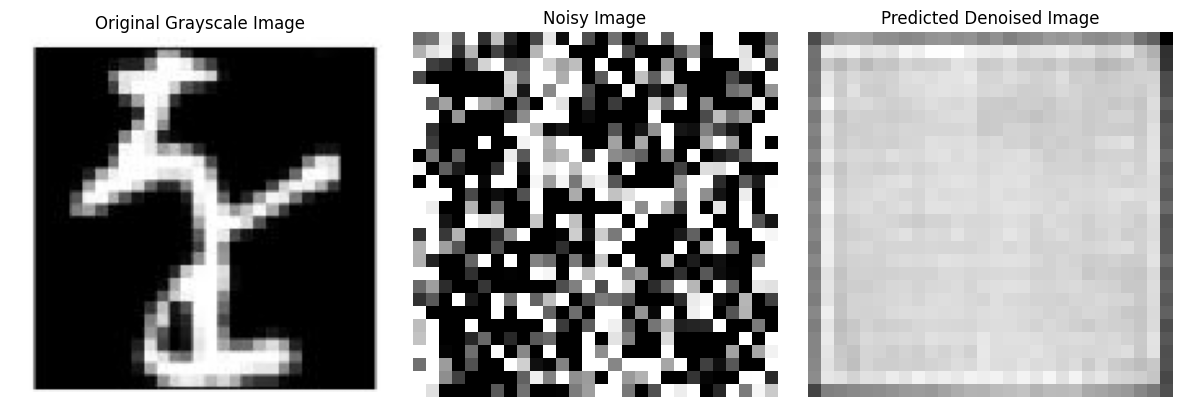

In [ ]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import numpy as np

# Ensure device is set to CPU
device = torch.device("cpu")
model.to(device)

# Define a function to add Gaussian noise to the image
def add_noise(image, noise_factor=.8):
    """Add random Gaussian noise to the image."""
    noisy_image = image + noise_factor * torch.randn_like(image)
    noisy_image = torch.clamp(noisy_image, 0., 1.)  # Ensure pixel values are within [0, 1]
    return noisy_image

# Define a function to visualize the grayscale, noisy, and denoised images
def plot_images(grayscale_image, noisy_image, denoised_image):
    """Display the original grayscale, noisy, and denoised images side by side."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Original grayscale image
    axes[0].imshow(grayscale_image, cmap='gray')
    axes[0].set_title("Original Grayscale Image")
    axes[0].axis("off")

    # Noisy image
    axes[1].imshow(noisy_image.squeeze().detach().cpu().numpy(), cmap='gray')
    axes[1].set_title("Noisy Image")
    axes[1].axis("off")

    # Denoised image
    axes[2].imshow(denoised_image.squeeze().detach().cpu().numpy(), cmap='gray')
    axes[2].set_title("Predicted Denoised Image")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Define an inference function
def infer_denoise(model, noisy_image):
    """Use the trained model to denoise a single image."""
    model.eval()
    with torch.no_grad():
        noisy_image = noisy_image.to(device)
        denoised_image = model(noisy_image.unsqueeze(0))  # Add batch dimension
        return denoised_image.squeeze(0)  # Remove batch dimension

# Load and preprocess the input image
def preprocess_image(image_path):
    """Load and preprocess an input image."""
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.Resize((28, 28)),  # Resize to 28x28
        transforms.ToTensor(),  # Convert to tensor
    ])
    image = Image.open(image_path).convert("RGB")  # Open image and convert to RGB
    return transform(image)  # Apply the transformations

# Example usage of the inference function
image_path = '/content/denoising.JPG'  # Replace with the actual image path

# Load the original grayscale image for visualization
grayscale_image = Image.open(image_path).convert("L")

# Preprocess the image to convert it into a tensor (grayscale)
original_image_tensor = preprocess_image(image_path).to(device)

# Add noise to the image
noisy_image = add_noise(original_image_tensor)

# Compute loss (ensure this method exists)
loss = get_loss(model, noisy_image.unsqueeze(0))  # Compute loss with batch dimension

# Denoise the image
denoised_output = infer_denoise(model, noisy_image)

# Visualize the result: original grayscale image, noisy image, and predicted denoised image
plot_images(grayscale_image, noisy_image, denoised_output)
